# 0. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import altair as alt
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer

# 1. Getting Source Data

In [2]:
dataset_df = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-02-11/hotels.csv")
dataset_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
print(f"Number of records: {dataset_df.shape[0]}")
print(f"Number of columns: {dataset_df.shape[1]}")

Number of records: 119390
Number of columns: 32


# 2. Understanding the problem

In this problem, we are trying to build a model to predict if a booking will be canceled based on the known parameters, We will be using the dataset cleaned by Thomas Mock and Antoine Bichat for [#TidyTuesday during the week of February 11th, 2020](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md). The data is originally from the article [Hotel Booking Demand Datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191), written by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019.

In this dataset, we have data from two hotels, one is located in city and the other one is a resort. We will assume that these two hotels follow general norms of hotel industry and the data is a representative sample for all the hotels for which we intend to use this model.

## 2.1. Target Column

- The target column is known as `is_canceled` which can have 2 values:
    - 0 represents if the booking was no canceled and 1 represents if the booking was canceled.
    
## 2.2. Features

- `hotel`: Resort Hotel or City Hotel. We will use this feature as type of hotel
- `lead_time`: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
- `arrival_date_year`: Year of arrival date
- `arrival_date_month`: Month of arrival date
- `arrival_date_week_number`: Week number of year for arrival date
- `arrival_date_day_of_month`: Day of arrival date
- `stays_in_weekend_nights`: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- `stays_in_week_nights`: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- `adults`: Number of adults
- `children`: Number of children
- `babies`: Number of babies
- `meal`: Type of meal booked. Categories are presented in standard hospitality meal packages:
    - Undefined/SC – no meal package;
    - BB – Bed & Breakfast;
    - HB – Half board (breakfast and one other meal – usually dinner);
    - FB – Full board (breakfast, lunch and dinner)
- `country`: Country of origin. Categories are represented in the ISO 3155–3:2013 format
- `market_segment`: Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- `distribution_channel`: Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- `is_repeated_guest`: Value indicating if the booking name was from a repeated guest (1) or not (0)
- `previous_cancellations`: Number of previous bookings that were cancelled by the customer prior to the current booking
- `previous_bookings_not_canceled`: Number of previous bookings not cancelled by the customer prior to the current booking
- `reserved_room_type`: Code of room type reserved. Code is presented instead of designation for anonymity reasons
- `assigned_room_type`: Code for the type of room assigned to the booking. 
    - Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons
- `booking_changes`: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
- `deposit_type`: Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:
    - No Deposit – no deposit was made;
    - Non Refund – a deposit was made in the value of the total stay cost;
    - Refundable – a deposit was made with a value under the total cost of stay.
- `agent`: ID of the travel agency that made the booking
- `company`: ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons
- `days_in_waiting_list`: Number of days the booking was in the waiting list before it was confirmed to the customer
- `customer_type`: Type of booking, assuming one of four categories:
    - Contract - when the booking has an allotment or other type of contract associated to it;
    - Group – when the booking is associated to a group;
    - Transient – when the booking is not part of a group or contract, and is not associated to other transient booking;
    - Transient-party – when the booking is transient, but is associated to at least other transient booking
- `adr`: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
- `required_car_parking_spaces`: Number of car parking spaces required by the customer
- `total_of_special_requests`: Number of special requests made by the customer (e.g. twin bed or high floor)
- `reservation_status`: Reservation last status, assuming one of three categories:
    - Canceled – booking was canceled by the customer;
    - Check-Out – customer has checked in but already departed;
    - No-Show – customer did not check-in and did inform the hotel of the reason why
- `reservation_status_date`: Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel


# 3. Data Splitting

In [4]:
chosen_seed = 2021
train_df, test_df = train_test_split(dataset_df, test_size = 0.1, random_state = chosen_seed)
print(f"Number of records in training set: {train_df.shape[0]}")
print(f"Number of records in test set: {test_df.shape[0]}")

Number of records in training set: 107451
Number of records in test set: 11939


# 4. Exploratory Data analysis

## 4.1. Data Summary

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107451 entries, 71168 to 91252
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           107451 non-null  object 
 1   is_canceled                     107451 non-null  int64  
 2   lead_time                       107451 non-null  int64  
 3   arrival_date_year               107451 non-null  int64  
 4   arrival_date_month              107451 non-null  object 
 5   arrival_date_week_number        107451 non-null  int64  
 6   arrival_date_day_of_month       107451 non-null  int64  
 7   stays_in_weekend_nights         107451 non-null  int64  
 8   stays_in_week_nights            107451 non-null  int64  
 9   adults                          107451 non-null  int64  
 10  children                        107447 non-null  float64
 11  babies                          107451 non-null  int64  
 12  meal         

In [6]:
train_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
hotel,107451,2,City Hotel,71353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_canceled,107451,NaN,NaN,NaN,0.370271,0.482879,0,0,0,1,1
lead_time,107451,NaN,NaN,NaN,104.046,106.872,0,18,69,160,737
arrival_date_year,107451,NaN,NaN,NaN,2016.16,0.706991,2015,2016,2016,2017,2017
arrival_date_month,107451,12,August,12455,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,107451,NaN,NaN,NaN,27.1543,13.6093,1,16,28,38,53
arrival_date_day_of_month,107451,NaN,NaN,NaN,15.7857,8.77582,1,8,16,23,31
stays_in_weekend_nights,107451,NaN,NaN,NaN,0.927697,0.998861,0,0,1,2,19
stays_in_week_nights,107451,NaN,NaN,NaN,2.50208,1.90983,0,1,2,3,50
adults,107451,NaN,NaN,NaN,1.85696,0.583306,0,2,2,2,55


## 4.2. Initial feature classification

In [7]:
numeric_features = [
    "lead_time",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "adr",
    "required_car_parking_spaces",
    "total_of_special_requests",
]
categorical_features = [
    "hotel",
    "arrival_date_month",
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "meal",
    "country",
    "market_segment",
    "distribution_channel",
    "is_repeated_guest",
    "reserved_room_type",
    "deposit_type",
    "agent",
    "company",
    "customer_type",
]
drop_features = [
    "arrival_date_year",
    "assigned_room_type",
    "reservation_status",
    "reservation_status_date",
]

## 4.3. Analysis of numeric features

### 4.3.1. Distribution of numeric features (wrt each target class)

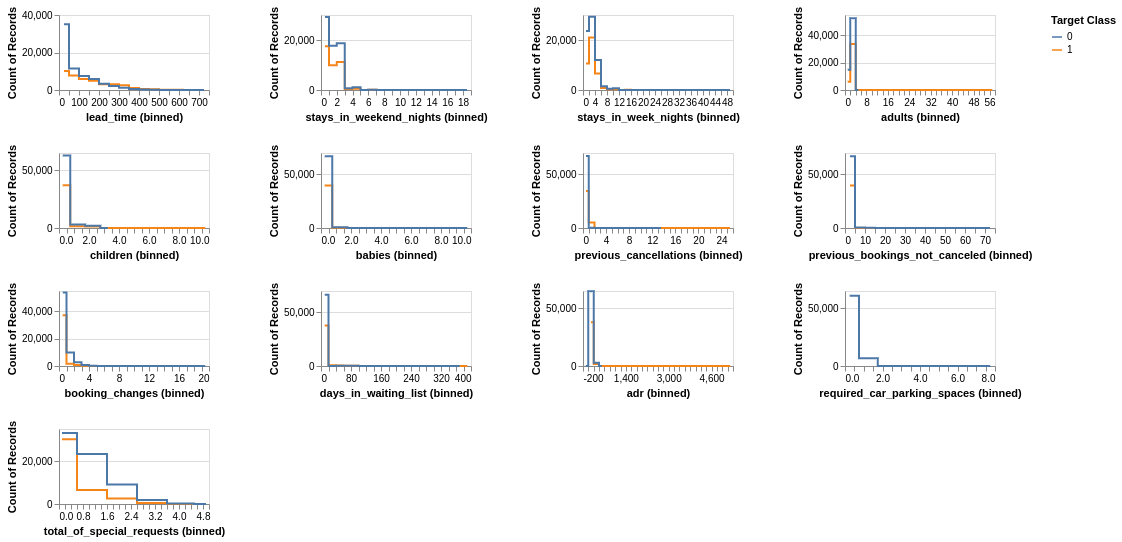

In [8]:
alt.Chart(train_df).mark_line(interpolate="step").encode(
    x=alt.X(alt.repeat("repeat"), type="quantitative", bin=alt.Bin(maxbins=30)),
    y="count()",
    color=alt.Color("is_canceled:N", title = "Target Class"),
).properties(width=150, height=75).repeat(repeat=numeric_features, columns=4)

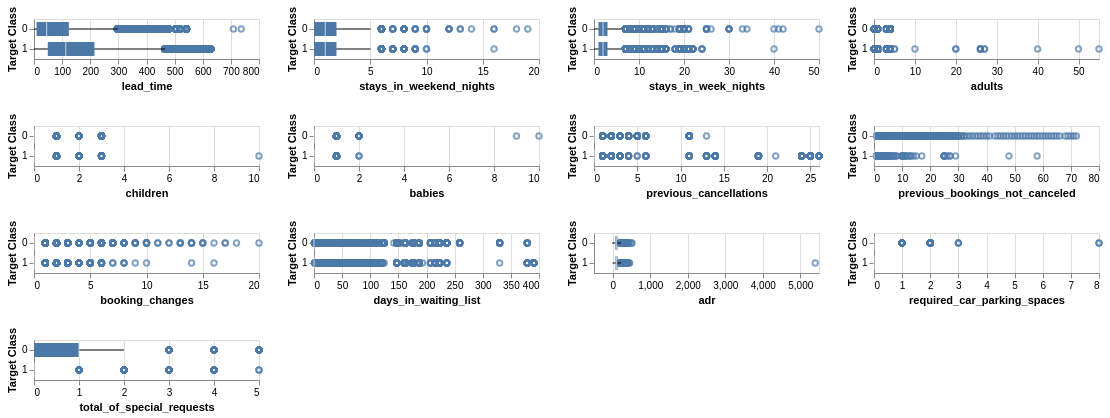

In [9]:
alt.Chart(train_df[numeric_features + ["is_canceled"]].reset_index()).mark_boxplot().encode(
    y=alt.Y("is_canceled:N", title="Target Class"),
    x=alt.X(
        alt.repeat("repeat"),
        type="quantitative",
        scale=alt.Scale(zero=False),
        #axis=alt.Axis(labels=False),
    ),
    tooltip="index"
).properties(width=225).repeat(repeat=numeric_features, columns=4)

### 4.3.2. Correlation of numeric features

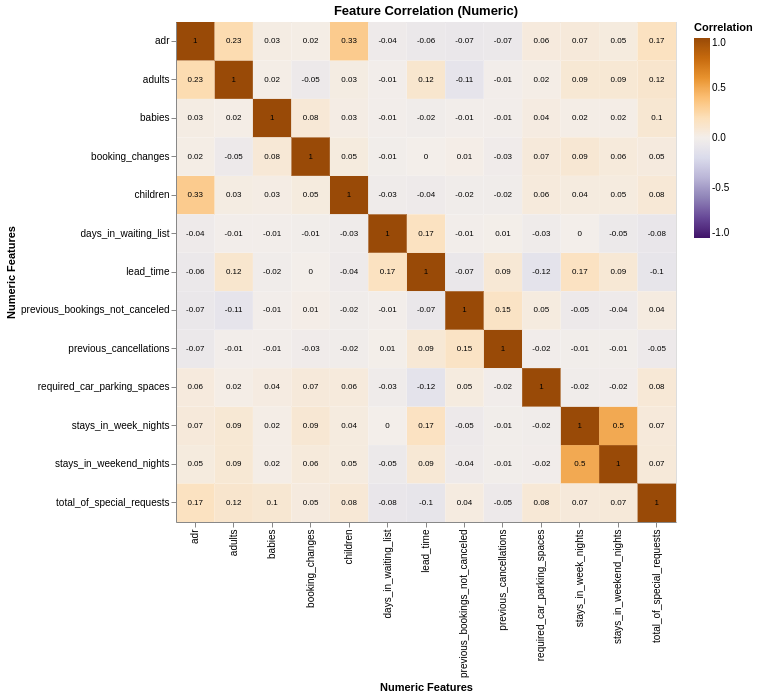

In [10]:
corr_df = train_df[numeric_features].corr().stack().reset_index(name="corr")
corr_df["round_corr"] = np.round(corr_df["corr"], 2)
corr_plot = (
    alt.Chart(corr_df, title="Feature Correlation (Numeric)")
    .mark_rect()
    .encode(
        x=alt.X("level_0", title="Numeric Features"),
        y=alt.Y("level_1", title="Numeric Features"),
        tooltip="corr",
        color=alt.Color("corr", scale=alt.Scale(domain=(-1, 1), scheme="purpleorange"), title="Correlation")
    )
    .properties(width=500, height=500)
)
corr_text = (
    alt.Chart(corr_df)
    .mark_text(size=8)
    .encode(
        x="level_0",
        y="level_1",
        text="round_corr",
    )
    .properties(width=500, height=500)
)
corr_plot + corr_text

## 4.4. Analysis of categorical features

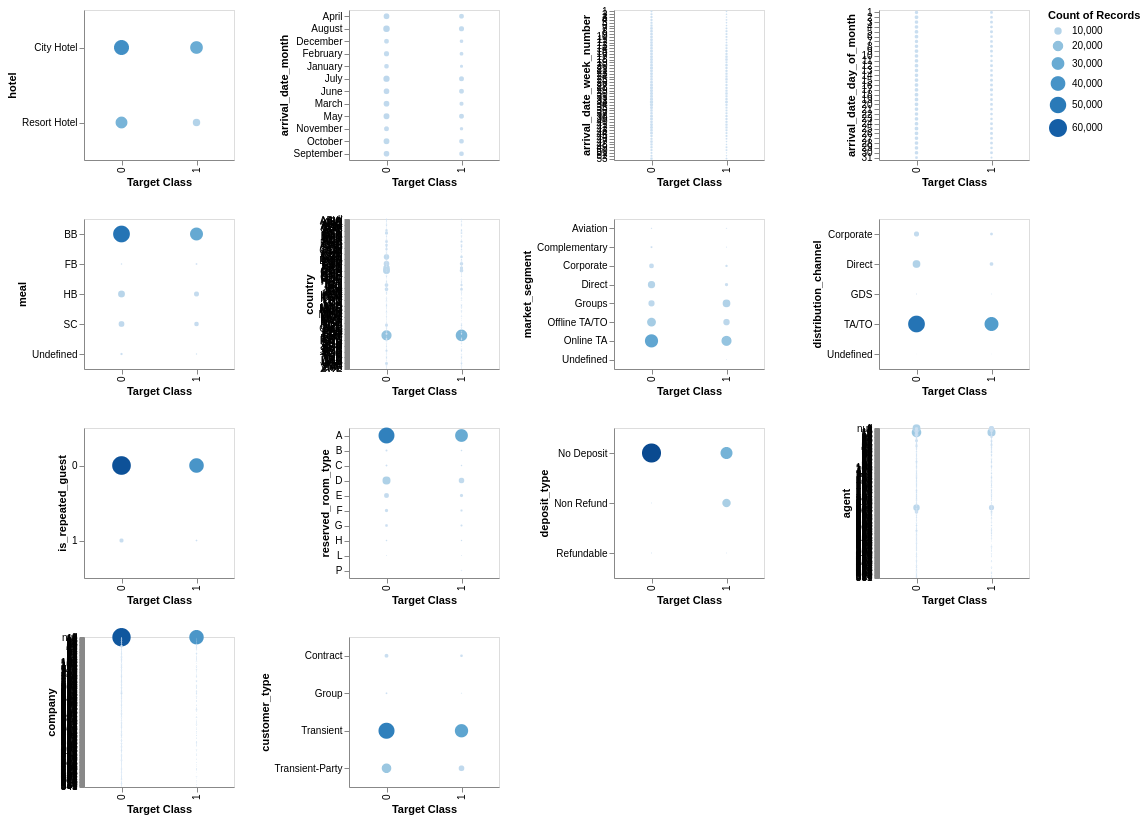

In [11]:

alt.Chart(
    train_df[categorical_features + ["is_canceled"]]
).mark_circle().encode(
    x=alt.X("is_canceled:N", title="Target Class"),
    y=alt.Y(alt.repeat("repeat"), type="nominal"),
    color="count()",
    size = "count()"
).properties(
    width=150, height=150
).repeat(
    repeat=categorical_features, columns=4
)

## 4.5. NULL Check
***

- There are 4 bookings with no information for children. This might have occurred due to data entry error as there were no significant information about children. Hence, we will impute 0 for them while building pipeline
- We will impute missing countries as `missing`
- We will investigate `agent` and `company` in next section

In [12]:
null_df = train_df.isna().sum().reset_index(name="null_count").rename(columns={"index": "feature_name"})
null_df = null_df.assign(null_perc=null_df["null_count"] / train_df.shape[0] * 100)
null_df[null_df["null_count"] != 0]

,feature_name,null_count,null_perc
10,children,4,0.003723
13,country,447,0.416004
23,agent,14691,13.672279
24,company,101301,94.276461


## 4.6. Checking specific features
***

### 4.6.1. Children

- There is one booking with 10 children and it is a potential outliar. Hence we will drop that booking from our training set

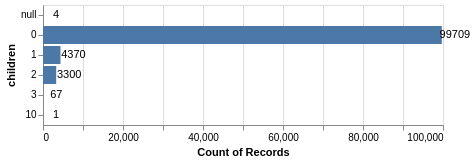

In [13]:
hist_plot = alt.Chart(train_df).mark_bar().encode(
    y=alt.Y("children:N"),
    x=alt.X("count()"),
)

hist_plot + hist_plot.mark_text(dx=13).encode(
    text="count()"
)

In [14]:
train_df.loc[train_df.children.isnull(), :]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
41160,City Hotel,1,8,2015,August,33,13,2,5,2,...,No Deposit,9.0,NaN,0,Transient-Party,76.5,0,1,Canceled,2015-08-09
40600,City Hotel,1,2,2015,August,32,3,1,0,2,...,No Deposit,NaN,NaN,0,Transient-Party,12.0,0,1,Canceled,2015-08-01
40679,City Hotel,1,1,2015,August,32,5,0,2,3,...,No Deposit,NaN,NaN,0,Transient-Party,18.0,0,2,Canceled,2015-08-04
40667,City Hotel,1,1,2015,August,32,5,0,2,2,...,No Deposit,14.0,NaN,0,Transient-Party,12.0,0,1,Canceled,2015-08-04


In [15]:
train_df.loc[train_df.children>3, :]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
328,Resort Hotel,1,55,2015,July,29,12,4,10,2,...,No Deposit,8.0,NaN,0,Contract,133.16,0,1,No-Show,2015-07-12


## 4.6.2. Babies

- There are 2 booking with more than 8 babies and they are potential outliars. Hence we will drop them

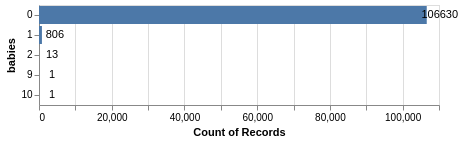

In [16]:
hist_plot = alt.Chart(train_df).mark_bar().encode(
    y=alt.Y("babies:N"),
    x=alt.X("count()"),
)

hist_plot + hist_plot.mark_text(dx=13).encode(
    text="count()"
)

In [17]:
train_df.query("babies>8")

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
46619,City Hotel,0,37,2016,January,3,12,0,2,2,...,No Deposit,9.0,NaN,0,Transient,84.45,0,1,Check-Out,2016-01-14
78656,City Hotel,0,11,2015,October,42,11,2,1,1,...,No Deposit,95.0,NaN,0,Transient-Party,95.00,0,0,Check-Out,2015-10-14


## 4.6.3. Agent

- There are 13.67% records without any agent. We will impute this with -1 (indicating no agent)
- 40.37% of city bookings are done by agent 9 and 35% resort booking was done by agent 240. We will consider them as preferred agent

In [18]:
null_df[null_df["null_count"] != 0].query("feature_name == 'agent'")

,feature_name,null_count,null_perc
23,agent,14691,13.672279


In [19]:
agent_stats = (
    pd.DataFrame(train_df.reset_index().groupby(["hotel", "agent"]).count()["index"])
    .reset_index()
    .rename(columns={"index": "counts"})
)
city_agent_stats = (
    agent_stats.query("hotel == 'City Hotel'")
    .sort_values(by="counts", ascending=False)
    .head()
)
city_agent_stats.assign(
    perc=city_agent_stats.counts / train_df.hotel.value_counts()["City Hotel"]*100
)

,hotel,agent,counts,perc
8,City Hotel,9.0,28808,40.373916
0,City Hotel,1.0,6428,9.008731
13,City Hotel,14.0,3278,4.594061
6,City Hotel,7.0,3164,4.434291
5,City Hotel,6.0,2404,3.369165


In [20]:
resort_agent_stats = (
    agent_stats.query("hotel == 'Resort Hotel'")
    .sort_values(by="counts", ascending=False)
    .head()
)
resort_agent_stats.assign(
    perc=resort_agent_stats.counts / train_df.hotel.value_counts()["Resort Hotel"]*100
)

,hotel,agent,counts,perc
291,Resort Hotel,240.0,12508,34.650119
299,Resort Hotel,250.0,2604,7.213696
292,Resort Hotel,241.0,1542,4.271705
234,Resort Hotel,40.0,903,2.501524
324,Resort Hotel,314.0,840,2.326999


## 4.6.4. Company

- 94% reservations are not made by any companies. We can drop this feature and create a boolean feature to indicate if the reservation is made by any company.

In [21]:
null_df[null_df["null_count"] != 0].query("feature_name == 'company'")

,feature_name,null_count,null_perc
24,company,101301,94.276461


## 4.6.5. ADR

- Only one average daily rate is 10 times higher than second highest average daily rate. This is a potential outliar. We will drop all records where ADR > 1000
- The median adr is 94.6
- We have 1761 records, where adr is less than or equal to 0. These reservations may indicate discounts and promotions

In [22]:
train_df.adr.sort_values(ascending=False)

48515     5400.00
111403     510.00
15083      508.00
103912     451.50
13142      450.00
           ...   
32341        0.00
106520       0.00
87099        0.00
112097       0.00
14969       -6.38
Name: adr, Length: 107451, dtype: float64

In [23]:
train_df.adr.median()

94.6

In [24]:
train_df[train_df.adr <= 0].shape[0]

1761

4.6.6 Required car parking

- Two records have exceptionally high parking requirements. These may be potential outliars and we will drop these records

In [25]:
train_df.required_car_parking_spaces.value_counts().reset_index(name="counts").rename(columns={"index":"required_car_parking_spaces"})

,required_car_parking_spaces,counts
0,0,100736
1,1,6685
2,2,25
3,3,3
4,8,2


## 4.7. Dropping outliars

In [26]:
train_df.shape

(107451, 32)

In [27]:
train_df = train_df[train_df.children<10]
train_df = train_df[train_df.babies<=8]
train_df = train_df[train_df.adr<=1000]
train_df = train_df[train_df.required_car_parking_spaces<=5]

In [28]:
train_df.shape

(107441, 32)

# 5. Feature Engineering

In [29]:
def f_is_company_paid(df):
    # is_company_paid=pd.Series(company.isna()==False, index = company.index, dtype=int, name="is_company_paid")
    df = df.assign(
        is_company_paid=pd.Series(df.company.isna() == False, dtype=int)
    )
    return df

In [30]:
def f_agent_type(hotel, agent):
    if np.isnan(agent):
        return "None"
    elif (hotel == "City Hotel") & (agent == 9):
        return "Preferred"
    elif (hotel == "Resort Hotel") & (agent == 240):
        return "Preferred"
    else:
        return "Other"


def f_agent_type_apply(df):
    df = df.assign(
        agent_type=df.apply(
            lambda row: f_agent_type(row["hotel"], row["agent"]), axis=1
        )
    )
    return df

In [31]:
def f_total_children(df):
    df["z"] = np.zeros(df.children.shape, dtype=int)
    df = df.assign(
        total_children=np.where(df["children"].isnull() == True, df["z"], df["children"])
        + np.where(df["babies"].isnull() == True, df["z"], df["babies"])
    )
    df = df.drop(columns=["z"])
    return df

In [32]:
# transformer1 = FunctionTransformer(f_is_company_paid)
# transformer2 = FunctionTransformer(f_agent_type_apply)
# transformer3 = FunctionTransformer(f_total_children)
# pipe = Pipeline([("test1", transformer1), ("test2", transformer2), ("test3", transformer3)])
# test = pipe.transform(train_df)
# test[["hotel", "agent", "agent_type", "is_company_paid", "total_children"]]

In [33]:
# test.is_company_paid[95888]

# 6. Preprocessing and transformations

In [34]:
numeric_features = [
    "lead_time",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "adr",
    "required_car_parking_spaces",
    "total_of_special_requests",
    "total_children",
]
children_feature = [
    "children",
    "babies",
]
categorical_features = [
    "hotel",
    "arrival_date_month",
    "arrival_date_week_number",
    "meal",
    "country",
    "market_segment",
    "distribution_channel",
    "reserved_room_type",
    "deposit_type",
    "customer_type",
    "agent_type",
]
drop_features = [
    "arrival_date_year",
    "arrival_date_day_of_month",
    "assigned_room_type",
    "reservation_status",
    "reservation_status_date",
    "company",
    "agent",
]
binary_features = ["is_company_paid", "is_repeated_guest"]

In [35]:
X_train, y_train = train_df.drop(columns=["is_canceled"]), train_df.is_canceled
X_test, y_test = test_df.drop(columns=["is_canceled"]), test_df.is_canceled

In [36]:
ft_is_company_paid = FunctionTransformer(f_is_company_paid)
ft_agent_type = FunctionTransformer(f_agent_type_apply)
ft_total_children = FunctionTransformer(f_total_children)

In [37]:
numeric_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)
binary_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"))
children_pipeline = make_pipeline(SimpleImputer(strategy="constant", fill_value=0), StandardScaler())
column_processor = make_column_transformer(
    (numeric_pipeline, numeric_features),
    (categorical_pipeline, categorical_features),
    (binary_pipeline, binary_features),
    (children_pipeline, children_feature),
    ("drop", drop_features)
)

In [38]:
preprocessor = make_pipeline(
    ft_is_company_paid,
    ft_agent_type,
    ft_total_children,
    column_processor,
)

# 7. Baseline model

# 8. Different classifiers

# 9. Feature selection

# 10. Hyperparameter optimization

# 11. Interpretation and feature importances

# 12. Results on the test set

# 13. Summary of the results